In [2]:
#Class.py
import numpy as np

class Option:
    def __init__(self):
        self.batch_size = 0
        self.iteration = 0
        
class NN:
    def __init__(self, **arg):
        init = {'layer':[],
                'active_function':'sigmoid', 
                'output_function':'sigmoid', 
                'learning_rate':1.5, 
                'weight_decay':0,
                'cost':{}, 
                'encoder':0,
                'sparsity':0.03,
                'beta':3,
                'batch_normalization':0,
                'grad_squared':0,
                'r':0,
                'optimization_method':'normal',
                'objective_function':'MSE'
               }
        
        param = dict() #字典结构实现参数列表
        param.update(init)
        param.update(arg)
        
        self.size = param['layer'] #取出字典的值初始化网络参数
        self.depth = len(self.size)
        self.active_function = param['active_function']
        self.output_function = param['output_function']
        self.learning_rate = param['learning_rate']
        self.weight_decay = param['weight_decay']
        self.encoder = param['encoder']
        self.sparsity = param['sparsity']
        self.beta = param['beta']
        self.cost = param['cost']
        self.batch_normalization = param['batch_normalization']
        self.grad_squared = param['grad_squared']
        self.r = param['r']
        self.optimization_method = param['optimization_method']
        self.objective_function = param['objective_function']
        self.a = dict()

        if self.objective_function == 'Cross Entropy':
            self.output_function = 'softmax'

        self.W = dict(); self.b = dict(); self.vW = dict(); self.vb = dict() #python必须要先初始化字典才能用
        self.rW = dict(); self.rb = dict(); self.sW = dict(); self.sb = dict() #注意要单独初始化，否则它们以后也一直是一样的
        self.E = dict(); self.S = dict(); self.Gamma = dict(); self.Beta = dict()
        self.vGamma = dict(); self.rGamma = dict(); self.vBeta = dict(); self.rBeta = dict(); 
        self.sGamma = dict(); self.sBeta = dict(); self.W_grad = dict(); self.b_grad = dict(); self.theta = dict()
        self.Gamma_grad = dict(); self.Beta_grad = dict()
        
        for k in range(self.depth - 1):
            width = self.size[k]
            height = self.size[k + 1]
            #self.W{ k } = (np.random.rand(height, width) - 0.5) * 2 * np.sqrt(6 / (height + width + 1)) - np.sqrt(6 / (height + width + 1));

            self.W[k] = 2 * np.random.rand(height, width) / np.sqrt(width) - 1 / np.sqrt(width)
            
            #self.W{ k } = 2 * np.random.rand(height, width) - 1;
            #Xavier initialization
            if self.active_function == 'relu':
                self.b[k] = np.random.rand(height, 1) + 0.01
            else:
                self.b[k] = 2 * np.random.rand(height, 1) / np.sqrt(width) - 1 / np.sqrt(width)

            #parameters for moments
            method = self.optimization_method

            if method == 'Momentum':
                self.vW[k] = np.zeros((height, width), dtype=float)
                self.vb[k] = np.zeros((height, 1), dtype=float)

            if method == 'AdaGrad' or method == 'RMSProp' or method == 'Adam':
                self.rW[k] = np.zeros((height, width), dtype=float)
                self.rb[k] = np.zeros((height, 1), dtype=float)

            if method == 'Adam':
                self.sW[k] = np.zeros((height, width), dtype=float)
                self.sb[k] = np.zeros((height, 1), dtype=float)

            #parameters for batch normalization.
            if self.batch_normalization:
                self.E[k] = np.zeros((height, 1), dtype=float)
                self.S[k] = np.zeros((height, 1), dtype=float)
                self.Gamma[k] = 1
                self.Beta[k] = 0

                if  method == 'Momentum':
                    self.vGamma[k] = 1
                    self.vBeta[k] = 0

                if method == 'AdaGrad' or method == 'RMSProp' or method == 'Adam':
                    self.rW[k] = np.zeros((height, width), dtype=float)
                    self.rb[k] = np.zeros((height, 1), dtype=float)
                    self.rGamma[k] = 0
                    self.rBeta[k] = 0

                if  method == 'Adam':
                    self.sGamma[k] = 1
                    self.sBeta[k] = 0

                self.vecNum = 0
                
            self.W_grad[k] = np.zeros((height, width), dtype=float)

In [3]:
#function.py
np.seterr(divide='ignore', invalid='ignore')

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    """返回对应的概率值"""
    exp_x = np.exp(x)
    softmax_x = np.zeros(x.shape,dtype=float)
    for i in range(len(x[0])):
        softmax_x[:,i] = exp_x[:,i] / (exp_x[0,i] + exp_x[1,i])
        
    return softmax_x 

In [4]:
#nn_applygradient.py

def nn_applygradient(nn):
    method = nn.optimization_method
    if method == 'AdaGrad' or method == 'RMSProp' or method == 'Adam':
        grad_squared = 0
        if nn.batch_normalization == 0:
            for k in range(nn.depth-1):
                grad_squared = grad_squared + sum(sum(nn.W_grad[k]**2)) + sum(nn.b_grad[k]**2)
        else:
            for k in range(nn.depth-1):
                grad_squared = grad_squared + sum(sum(nn.W_grad[k]**2)) + sum(nn.b_grad[k]**2) + nn.Gamma[k]**2 + nn.Beta[k]**2

    for k in range(nn.depth-1):
        if nn.batch_normalization == 0:
            if method == 'normal':
                nn.W[k] = nn.W[k] - nn.learning_rate*nn.W_grad[k]
                nn.b[k] = nn.b[k] - nn.learning_rate*nn.b_grad[k]
                
            elif method == 'AdaGrad':
                nn.rW[k] = nn.rW[k] + nn.W_grad[k]**2
                nn.rb[k] = nn.rb[k] + nn.b_grad[k]**2
                nn.W[k] = nn.W[k] - nn.learning_rate*nn.W_grad[k]/(np.sqrt(nn.rW[k]) + 0.001)
                nn.b[k] = nn.b[k] - nn.learning_rate*nn.b_grad[k]/(np.sqrt(nn.rb[k]) + 0.001)
                
            elif method == 'Momentum':
                rho = 0.1 #rho = 0.1
                nn.vW[k] = rho * nn.vW[k] - nn.learning_rate*nn.W_grad[k]
                nn.vb[k] = rho * nn.vb[k] - nn.learning_rate*nn.b_grad[k]
                nn.W[k] = nn.W[k] + nn.vW[k]
                nn.b[k] = nn.b[k] + nn.vb[k]

            elif method == 'RMSProp':
                rho = 0.9 #rho = 0.9
                nn.rW[k] = rho * nn.rW[k] + 0.1*nn.W_grad[k]**2
                nn.rb[k] = rho * nn.rb[k] + 0.1*nn.b_grad[k]**2

                nn.W[k] = nn.W[k] - nn.learning_rate*nn.W_grad[k]/(np.sqrt(nn.rW[k]) + 0.001)
                nn.b[k] = nn.b[k] - nn.learning_rate*nn.b_grad[k]/(np.sqrt(nn.rb[k]) + 0.001) #rho = 0.9

            elif method == 'Adam':
                rho1 = 0.9
                rho2 = 0.999
                nn.sW[k] = 0.9*nn.sW[k] + 0.1*nn.W_grad[k]
                nn.sb[k] = 0.9*nn.sb[k] + 0.1*nn.b_grad[k]
                nn.rW[k] = 0.999*nn.rW[k] + 0.001*nn.W_grad[k]**2
                nn.rb[k] = 0.999*nn.rb[k] + 0.001*nn.b_grad[k]**2

                newS = nn.sW[k] / (1 - rho1)
                newR = nn.rW[k] / (1 - rho2)
                nn.W[k] = nn.W[k] - nn.learning_rate*newS/np.sqrt(newR + 0.00001)
                newS = nn.sb[k] / (1 - rho1)
                newR = nn.rb[k] / (1 - rho2)
                nn.b[k] = nn.b[k] -nn.learning_rate*newS/np.sqrt(newR + 0.00001)#rho1 = 0.9, rho2 = 0.999, delta = 0.00001

        else:
            if method == 'normal':
                nn.W[k] = nn.W[k] - nn.learning_rate*nn.W_grad[k]
                nn.b[k] = nn.b[k] - nn.learning_rate*nn.b_grad[k]
                nn.Gamma[k] = nn.Gamma[k] - nn.learning_rate*nn.Gamma_grad[k]
                nn.Beta[k] = nn.Beta[k] - nn.learning_rate*nn.Beta_grad[k]
                
            elif method == 'AdaGrad':
                nn.rW[k] = nn.rW[k] + nn.W_grad[k]**2
                nn.rb[k] = nn.rb[k] + nn.b_grad[k]**2
                nn.rGamma[k] = nn.rGamma[k] + nn.Gamma_grad[k]**2
                nn.rBeta[k] = nn.rBeta[k] + nn.Beta_grad[k]**2
                nn.W[k] = nn.W[k] - nn.learning_rate*nn.W_grad[k]/(np.sqrt(nn.rW[k]) + 0.001)
                nn.b[k] = nn.b[k] - nn.learning_rate*nn.b_grad[k]/(np.sqrt(nn.rb[k]) + 0.001)
                nn.Gamma[k] = nn.Gamma[k] - nn.learning_rate*nn.Gamma_grad[k] / (np.sqrt(nn.rGamma[k]) + 0.001)
                nn.Beta[k] = nn.Beta[k] - nn.learning_rate*nn.Beta_grad[k] / (np.sqrt(nn.rBeta[k]) + 0.001)
                
            elif method == 'RMSProp':
                nn.rW[k] = 0.9*nn.rW[k] + 0.1*nn.W_grad[k]**2
                nn.rb[k] = 0.9*nn.rb[k] + 0.1*nn.b_grad[k]**2
                nn.rGamma[k] = 0.9*nn.rGamma[k] + 0.1*nn.Gamma_grad[k]**2
                nn.rBeta[k] = 0.9*nn.rBeta[k] + 0.1*nn.Beta_grad[k]**2
                nn.W[k] = nn.W[k] - nn.learning_rate*nn.W_grad[k]/(np.sqrt(nn.rW[k]) + 0.001)
                nn.b[k] = nn.b[k] - nn.learning_rate*nn.b_grad[k]/(np.sqrt(nn.rb[k]) + 0.001)
                nn.Gamma[k] = nn.Gamma[k] - nn.learning_rate*nn.Gamma_grad[k] / (np.sqrt(nn.rGamma[k]) + 0.001)
                nn.Beta[k] = nn.Beta[k] - nn.learning_rate*nn.Beta_grad[k] / (np.sqrt(nn.rBeta[k]) + 0.001) #rho = 0.9

            elif method == 'Momentum':
                rho = 0.1 #rho = 0.1
                nn.vW[k] = rho * nn.vW[k] - nn.learning_rate*nn.W_grad[k]
                nn.vb[k] = rho * nn.vb[k] - nn.learning_rate*nn.b_grad[k]
                nn.vGamma[k] = rho * nn.vGamma[k] - nn.learning_rate*nn.Gamma_grad[k]
                nn.vBeta[k] = rho * nn.vBeta[k] - nn.learning_rate*nn.Beta_grad[k]
                nn.W[k] = nn.W[k] + nn.vW[k]
                nn.b[k] = nn.b[k] + nn.vb[k]
                nn.Gamma[k] = nn.Gamma[k] + nn.vGamma[k]
                nn.Beta[k] = nn.Beta[k] + nn.vBeta[k]

            elif method == 'Adam':
                nn.sW[k] = 0.9*nn.sW[k] + 0.1*nn.W_grad[k]
                nn.sb[k] = 0.9*nn.sb[k] + 0.1*nn.b_grad[k]
                nn.sGamma[k] = 0.9*nn.sGamma[k] + 0.1*nn.Gamma_grad[k]
                nn.sBeta[k] = 0.9*nn.sBeta[k] + 0.1*nn.Beta_grad[k]
                nn.rW[k] = 0.999*nn.rW[k] + 0.001*nn.W_grad[k]**2
                nn.rb[k] = 0.999*nn.rb[k] + 0.001*nn.b_grad[k]**2
                nn.rBeta[k] = 0.999*nn.rBeta[k] + 0.001*nn.Beta_grad[k]**2
                nn.rGamma[k] = 0.999*nn.rGamma[k] + 0.001*nn.Gamma_grad[k]**2
                nn.W[k] = nn.W[k] -10 * nn.learning_rate*nn.sW[k]/np.sqrt(1000 * nn.rW[k]+0.00001)
                nn.b[k] = nn.b[k] -10 * nn.learning_rate*nn.sb[k]/np.sqrt(1000 * nn.rb[k]+0.00001)
                nn.Gamma[k] = nn.Gamma[k] -10 * nn.learning_rate*nn.sGamma[k]/np.sqrt(1000 * nn.rGamma[k]+0.00001)
                nn.Beta[k] = nn.Beta[k] -10 * nn.learning_rate*nn.sBeta[k]/np.sqrt(1000 * nn.rBeta[k]+0.00001) #rho1 = 0.9, rho2 = 0.999, delta = 0.00001

    return nn

In [6]:
#nn_forward.py
def nn_forward(nn, batch_x, batch_y):
    s = len(nn.cost) + 1 
    batch_x = batch_x.T 
    batch_y = batch_y.T 
    m = batch_x.shape[1]
    nn.a[0] = batch_x 

    cost2 = 0 
    for k in range(1, nn.depth):
        y = np.dot(nn.W[k-1], nn.a[k-1]) + np.tile(nn.b[k-1], (1, m)) #np.tile就是matlab中的repmat(replicate matrix)
        
        if nn.batch_normalization:
            nn.E[k-1] = nn.E[k-1]*nn.vecNum + np.array([np.sum(y, axis=1)]).T
            nn.S[k-1] = nn.S[k-1]**2 * (nn.vecNum - 1) + np.array([(m - 1)*np.std(y,ddof=1,axis=1)** 2]).T #ddof=1计算无偏估计
            nn.vecNum = nn.vecNum + m 
            nn.E[k-1] = nn.E[k-1] / nn.vecNum 
            nn.S[k-1] = np.sqrt(nn.S[k-1] / (nn.vecNum - 1)) 
            y = (y - np.tile(nn.E[k-1], (1, m))) / np.tile(nn.S[k-1]+0.0001*np.ones(nn.S[k-1].shape), (1, m)) 
            y = nn.Gamma[k-1]*y + nn.Beta[k-1] 

        if k == nn.depth - 1:
            f = nn.output_function
            if f == 'sigmoid' :
                nn.a[k] = sigmoid(y)
            elif f == 'tanh' :
                nn.a[k] = np.tanh(y)
            elif f == 'relu' :
                nn.a[k] = np.maximum(y, 0)
            elif f == 'softmax' :
                nn.a[k] = softmax(y)

        else:
            f = nn.active_function
            if f == 'sigmoid' :
                nn.a[k] = sigmoid(y)
            elif f == 'tanh' :
                nn.a[k] = np.tanh(y)
            elif f == 'relu' :
                nn.a[k] = np.maximum(y, 0)

        cost2 = cost2 + np.sum(nn.W[k-1]**2)

    if nn.encoder == 1:
        roj = np.sum(nn.a[2], axis=1) / m 
        nn.cost[s] = 0.5 * np.sum((nn.a[k] -batch_y)**2) / m + 0.5 * nn.weight_decay * cost2 + 3 * sum(nn.sparsity * np.log(nn.sparsity / roj) + (1-nn.sparsity) * np.log((1-nn.sparsity) / (1-roj)))
    else:
        if nn.objective_function == 'MSE':
            nn.cost[s] = 0.5 / m * sum(sum((nn.a[k] -batch_y)** 2)) + 0.5 * nn.weight_decay * cost2 
        elif nn.objective_function == 'Cross Entropy':
            nn.cost[s] = -0.5 * sum(sum(batch_y*np.log(nn.a[k]))) / m + 0.5 * nn.weight_decay * cost2 
    # nn.cost[s]
    
    return nn

In [7]:
#nn_backpropagation.py

def nn_backpropagation(nn, batch_y) :
    batch_y = batch_y.T
    m = nn.a[0].shape[1]
    nn.theta[1] = 0
    f = nn.output_function
    if f == 'sigmoid' :
        nn.theta[nn.depth-1] = -(batch_y - nn.a[nn.depth-1]) * nn.a[nn.depth-1] * (1 - nn.a[nn.depth-1])
    if f == 'tanh' :
        nn.theta[nn.depth-1] = -(batch_y - nn.a[nn.depth-1]) * (1 - nn.a[nn.depth-1]**2)
    if f == 'softmax' :
        y = np.dot(nn.W[nn.depth - 2], nn.a[nn.depth - 2]) + np.tile(nn.b[nn.depth - 2], (1, m))
        nn.theta[nn.depth-1] = nn.a[nn.depth-1] - batch_y

    if nn.batch_normalization :
        x = np.dot(nn.W[nn.depth - 2], nn.a[nn.depth -2]) + np.tile(nn.b[nn.depth - 2], (1, m))
        x = (x - np.tile(nn.E[nn.depth -2], (1, m))) / np.tile(nn.S[nn.depth -2] + 0.0001*np.ones(nn.S[nn.depth - 2].shape), (1, m))
        temp = nn.theta[nn.depth-1] * x
        nn.Gamma_grad[nn.depth - 2] = sum(np.mean(temp, axis = 1))
        nn.Beta_grad[nn.depth - 2] = sum(np.mean(nn.theta[nn.depth-1], axis = 1))
        nn.theta[nn.depth - 1] = nn.Gamma[nn.depth - 2]*nn.theta[nn.depth-1] / np.tile((nn.S[nn.depth - 2] + 0.0001), (1, m))

    nn.W_grad[nn.depth - 2] = np.dot(nn.theta[nn.depth-1], nn.a[nn.depth - 2].T) / m + nn.weight_decay*nn.W[nn.depth - 2]
    nn.b_grad[nn.depth - 2] = np.array([np.sum(nn.theta[nn.depth-1], axis=1) / m]).T 
    #因为np.sum()返回维度为(n,)，会让之后的加法操作错误，所以要转换为(n,1)维度矩阵，下面的也是一样
    
    f = nn.active_function
    if f == 'sigmoid':
        if nn.encoder == 0 :
            for ll in range(1, nn.depth - 1) :
                k = nn.depth - ll-1
                nn.theta[k] = np.dot(nn.W[k].T, nn.theta[k + 1])*nn.a[k]* (1 - nn.a[k])
                if nn.batch_normalization :
                    x = np.dot(nn.W[k - 1], nn.a[k - 1]) + np.tile(nn.b[k - 1], (1, m))
                    x = (x - np.tile(nn.E[k - 1], (1, m))) / np.tile(nn.S[k - 1] + 0.0001*np.ones(nn.S[k - 1].shape), (1, m))
                    temp = nn.theta[k]*x
                    nn.Gamma_grad[k - 1] = sum(np.mean(temp, axis = 1))
                    nn.Beta_grad[k - 1] = sum(np.mean(nn.theta[k], axis = 1))
                    nn.theta[k] = (nn.Gamma[k - 1]* nn.theta[k]) / np.tile((nn.S[k - 1] + 0.0001), (1, m))
                    pass

                nn.W_grad[k - 1] = np.dot(nn.theta[k], nn.a[k - 1].T) / m + nn.weight_decay*nn.W[k - 1]
                nn.b_grad[k - 1] = np.array([np.sum(nn.theta[k], axis = 1) / m]).T

        else:
            #encoder完全按照matlab的NN，但貌似是有错误的，用encoder会报错，因为theta[2]（对应matlab的theta{3}）没有赋值
            roj = np.array([np.sum(nn.a[1], axis = 1) / m]).T 
            temp = (-nn.sparsity / roj + (1 - nn.sparsity) / (1 - roj))
            nn.theta[1] = (np.dot(nn.W[1].T, nn.theta[2]) + nn.beta*repmat(temp, 1, m))*M
            nn.W_grad[0] = np.dot(nn.theta[1], nn.a[0].T) / m + nn.weight_decay*nn.W[0]
            nn.b_grad[0] = np.array([np.sum(nn.theta[1], axis = 1) / m]).T
            

    elif f == 'tanh':
        for ll in range(1, nn.depth-1) :
            if nn.encoder == 0 :
                k = nn.depth - ll-1 
                nn.theta[k] = np.dot(nn.W[k].T,nn.theta[k + 1])*(1 - nn.a[k]**2)
                if nn.batch_normalization :
                    x = np.dot(nn.W[k - 1], nn.a[k - 1]) + np.tile(nn.b[k - 1], (1, m))
                    x = (x - np.tile(nn.E[k - 1], (1, m))) / np.tile(nn.S[k - 1] + 0.0001*np.ones(nn.S[k - 1].shape), (1, m))
                    temp = nn.theta[k]*x
                    nn.Gamma_grad[k - 1] = sum(np.mean(temp, axis = 1))
                    nn.Beta_grad[k - 1] = sum(np.mean(nn.theta[k], axis = 1))
                    nn.theta[k] = (nn.Gamma[k - 1]* nn.theta[k]) / np.tile((nn.S[k - 1] + 0.0001), (1, m))
                    pass

                nn.W_grad[k - 1] = np.dot(nn.theta[k], nn.a[k - 1].T) / m + nn.weight_decay*nn.W[k - 1]
                nn.b_grad[k - 1] = np.array([np.sum(nn.theta[k], axis = 1) / m]).T

            else:
                roj = np.array([np.sum(nn.a[1], axis = 1) / m]).T
                temp = (-nn.sparsity / roj + (1 - nn.sparsity) / (1 - roj))
                nn.theta[1] = (np.dot(nn.W[1].T, nn.theta[2]) + nn.beta*repmat(temp, 1, m))*M
                nn.W_grad[0] = np.dot(nn.theta[1], nn.a[0].T) / m + nn.weight_decay*nn.W[0]
                nn.b_grad[0] = np.array([np.sum(nn.theta[1], axis = 1) / m]).T

    elif f == 'relu':
        if nn.encoder == 0 :
            for ll in range(1, nn.depth - 1) :
                k = nn.depth - ll-1
                nn.theta[k] = np.dot(nn.W[k].T,nn.theta[k + 1])* (nn.a[k] > 0)
                if nn.batch_normalization :
                    x = np.dot(nn.W[k - 1], nn.a[k - 1]) + np.tile(nn.b[k - 1], (1, m))
                    x = (x - np.tile(nn.E[k - 1], (1, m))) / np.tile(nn.S[k - 1] + 0.0001*np.ones(nn.S[k - 1].shape), (1, m))
                    temp = nn.theta[k]*x
                    nn.Gamma_grad[k - 1] = sum(np.mean(temp, axis = 1))
                    nn.Beta_grad[k - 1] = sum(np.mean(nn.theta[k], axis = 1))
                    nn.theta[k] = (nn.Gamma[k - 1]* nn.theta[k]) / np.tile((nn.S[k - 1] + 0.0001), (1, m))
                    pass

                nn.W_grad[k - 1] = np.dot(nn.theta[k], nn.a[k - 1].T) / m + nn.weight_decay*nn.W[k - 1]
                nn.b_grad[k - 1] = np.array([np.sum(nn.theta[k], axis = 1) / m]).T

        else:
            roj = np.array([np.sum(nn.a[1], axis = 1) / m]).T
            temp = (-nn.sparsity / roj + (1 - nn.sparsity) / (1 - roj))
            M = np.maximum(nn.a[1], 0)
            M = M / np.maximum(M, 0.001)

            nn.theta[1] = (np.dot(nn.W[1].T, nn.theta[2]) + nn.beta*repmat(temp, 1, m))*M
            nn.W_grad[0] = np.dot(nn.theta[1], nn.a[0].T) / m + nn.weight_decay*nn.W[0]
            nn.b_grad[0] = np.array([np.sum(nn.theta[1], axis = 1) / m]).T
    return nn

In [8]:
#nn_predict.py

def nn_predict(nn, batch_x):
    batch_x = batch_x.T 
    m = batch_x.shape[1]
    nn.a[0] = batch_x 
    for k in range(1, nn.depth):
        y = np.dot(nn.W[k-1], nn.a[k-1]) + np.tile(nn.b[k-1], (1, m))
        if nn.batch_normalization:
            y = (y - np.tile(nn.E[k-1], (1, m))) / np.tile(nn.S[k-1]+0.0001*np.ones(nn.S[k-1].shape), (1, m)) 
            y = nn.Gamma[k-1]*y + nn.Beta[k-1] 

        if k == nn.depth-1:
            f = nn.output_function
            if f == 'sigmoid':
                nn.a[k] = sigmoid(y) 
            elif f == 'tanh':
                nn.a[k] = np.tanh(y) 
            elif f == 'relu':
                nn.a[k] = np.maximum(y, 0) 
            elif f == 'softmax':
                nn.a[k] = softmax(y) 

        else:
            f = nn.active_function
            if f == 'sigmoid':
                nn.a[k] = sigmoid(y) 
            elif f == 'tanh':
                nn.a[k] = np.tanh(y) 
            elif f == 'relu':
                nn.a[k] = np.maximum(y, 0) 
            
    return nn

In [9]:
#nn_train.py

def nn_train(nn,option,train_x,train_y):
    iteration = option.iteration
    batch_size = option.batch_size
    m = train_x.shape[0]
    num_batches = m / batch_size
    for k in range(iteration): 
        kk = np.random.permutation(m)
        for l in range(int(num_batches)):
            batch_x = train_x[kk[l * batch_size : (l + 1) * batch_size], :] #(l+1)*batch_size也可以改成max((l+1)*batch_size, len(kk))
            batch_y = train_y[kk[l * batch_size : (l + 1) * batch_size], :]
            nn = nn_forward(nn,batch_x,batch_y)
            nn = nn_backpropagation(nn,batch_y)
            nn = nn_applygradient(nn)
            
    return nn

In [10]:
#nn_test.py

def nn_test(nn,test_x,test_y):
    nn = nn_predict(nn,test_x)
    y_output = nn.a[nn.depth-1]
    y_output = y_output.T
    label = np.argmax(y_output, axis=1) #按行找出最大元素所在下标
    expectation = np.argmax(test_y, axis=1)
    wrongs = sum(label != expectation) #求预测与期望不相等的个数
    success_ratio = 1-wrongs/test_y.shape[0]
    
    return wrongs, success_ratio

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from matplotlib.pyplot import *

def nn_testChess():
    with open('krkopt.data') as my_data:  # 读取文件部分
        lines = my_data.readlines()
        data = np.zeros((28056, 6), dtype=float)
        label = np.zeros((28056, 2), dtype=float)
        i = 0
        for line in lines:
            line = line.split(',')  # 以逗号分开
            if i == 0:
                line[0] = 'a'  # 不知道为什么第一个数据乱码，用写字板打开是'a'

            line[0] = ord(line[0]) - 96
            line[1] = float(line[1]) - 48
            line[2] = ord(line[2]) - 96
            line[3] = float(line[3]) - 48
            line[4] = ord(line[4]) - 96
            line[5] = float(line[5]) - 48
            data[i, :] = line[:-1]

            if line[6][0] == 'd':
                label[i] = np.array([1, 0])
            else:
                label[i] = np.array([0, 1])
            i += 1
            if i == 28056:
                break

    ratioTraining = 0.4
    ratioValidation = 0.1
    ratioTesting = 0.5
    xTraining, xTesting, yTraining, yTesting = train_test_split(data, label, test_size=1 - ratioTraining,
                                                                random_state=0)  # 随机分配数据集
    xTesting, xValidation, yTesting, yValidation = train_test_split(xTesting, yTesting,
                                                                    test_size=ratioValidation / ratioTesting,
                                                                    random_state=0)
    # 拆分成测试集和验证集

    scaler = StandardScaler(copy=False)
    scaler.fit(xTraining)
    scaler.transform(xTraining)  # 标准归一化
    scaler.transform(xTesting)
    scaler.transform(xValidation)

    nn = NN(layer=[6, 20, 20, 20, 2], active_function='relu', learning_rate=0.01, batch_normalization=1,
            optimization_method='Adam',
            objective_function='Cross Entropy')

    option = Option()
    option.batch_size = 50
    option.iteration = 1

    iteration = 0
    maxAccuracy = 0
    totalAccuracy = []
    totalCost = []
    maxIteration = 20
    while iteration < maxIteration:
        iteration = iteration + 1
        nn = nn_train(nn, option, xTraining, yTraining)
        totalCost.append(sum(nn.cost.values()) / len(nn.cost.values()))
        # plot(totalCost)
        (wrongs, accuracy) = nn_test(nn, xValidation, yValidation)
        totalAccuracy.append(accuracy)
        if accuracy > maxAccuracy:
            maxAccuracy = accuracy
            storedNN = nn

        cost = totalCost[iteration - 1]
        print(accuracy)
        print(totalCost[iteration - 1])

    subplot(2, 1, 1)
    plot(totalCost, color='red')
    title('Average Objective Function Value on the Training Set')

    subplot(2, 1, 2)
    plot(totalAccuracy, color='red')
    ylim([0.8, 1])
    title('Accuracy on the Validation Set')
    tight_layout(2)
    show()

    wrongs, accuracy = nn_test(storedNN, xTesting, yTesting)
    print('acc:', accuracy)



0.9664389664389664
0.11221213245131223
0.9934659934659935
0.06987707183838372
0.9937629937629937
0.05265935120050501
0.9946539946539946
0.04306624606082997
0.9946539946539946
0.03687409614193872
0.994059994059994
0.03251824275208296
0.9952479952479952
0.029221841552463493
0.9943569943569943
0.02661989552649125
0.994059994059994
0.024557498981575922
0.9958419958419958
0.022799409439782668
0.9946539946539946
0.021324239093081128
0.9931689931689932
0.020071651196202134
0.9949509949509949
0.018992656698056058
0.9946539946539946
0.018034763429927624
0.9964359964359965
0.01720508364783913
0.9961389961389961
0.016435860682391775
0.9955449955449955
0.01575862078779709
0.9961389961389961
0.015145801362436638
0.9970299970299971
0.01459997157800423
0.9931689931689932
0.014093859497147468


<ipython-input-12-f0b85e1ade3c>:84: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  tight_layout(2)


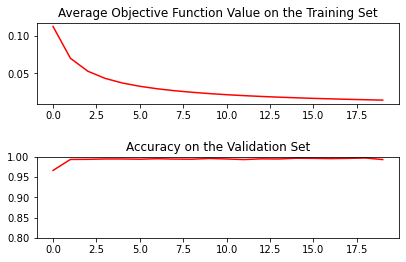

acc: 0.9932427415162991


In [15]:
nn_testChess()